In [1]:
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from ipywidgets import interact, fixed, FloatSlider
import pathlib
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fastprogress

sns.set()
sns.set_style("whitegrid")


# Bag of Tricks for Recommender Systems Post-processing    
Martin Boyanov     
10.01.2022    
Dev.BG, Zoom

<hr>

About the speaker:
1. Working with recommender systems for the past two years @ Smule Bulgaria
2. Worked on NLP problems and graph processing
3. MSc Information Retrieval and Knowledge Discovery @ Sofia University
4. BEng Software Engineering with Managament @ Edinburgh University

<img src="img/marty.jpg" width="500" style="border-radius:15px">

Contacts:     
[mboyanov@gmail.com](mailto:mboyanov@gmail.com)    
[LinkedIn](https://www.linkedin.com/in/martin-boyanov-1ab2124a/)

<hr> 


## The Demo

For demonstration purposes, we will be using a dataset and interactive widgets to better grasp the ideas. 

Technology: [Jupyter notebook](https://jupyter.org/) & [Voila](https://voila.readthedocs.io)

Data: [MovieLens latest](https://grouplens.org/datasets/movielens/) - 27,000,000 ratings for 58,000 movies made by 280,000 users

Model: It doesn't matter, but we will be working with a similarity model. Given a movie, recommend similar movies.

<hr> 

Examples: `Memento`, `Yu-gi-Oh!`, `Aliens`

In [14]:
BASE_PATH = pathlib.Path("/data/data/movielens/")
BASE_PATH.mkdir(exist_ok=True, parents=True)

if not (BASE_PATH / 'ml-latest.zip').exists():
    !wget -P {BASE_PATH} https://files.grouplens.org/datasets/movielens/ml-latest.zip
if not (BASE_PATH / 'ml-latest').exists():
    !unzip {BASE_PATH / "ml-latest.zip"} -d {BASE_PATH}  

In [3]:
movies = pd.read_csv(BASE_PATH / "ml-latest" / "movies.csv")
data = pd.read_csv(BASE_PATH / "ml-latest" / "ratings.csv")
user_bias = data.groupby('userId')['rating'].mean()
user_bias.name = 'user_bias'
data = pd.merge(data, user_bias, left_on='userId', right_index= True)
data['debiased_rating'] = data['rating'] - data['user_bias']

In [4]:
movie_counts = data.groupby('movieId').size()
common_movies = movie_counts.loc[movie_counts > 5]
data = data.loc[data.movieId.isin(common_movies.index)]
movies = movies.loc[movies.movieId.isin(common_movies.index)]

In [5]:
movieId2id = {}
for i, (movieId, count) in enumerate(data.movieId.value_counts().iteritems()):
    movieId2id[movieId] = i

In [6]:
data['movieId2'] = data['movieId'].map(movieId2id)
movies['movieId2'] = movies['movieId'].map(movieId2id)

In [7]:
movies = movies.set_index('movieId2').sort_index()

In [8]:
def compute_similarities():
    matrix = coo_matrix((data['debiased_rating'], (data['userId'], data['movieId2'])))
    matrix = matrix.tocsr()
    sims = cosine_similarity(matrix.transpose(),dense_output=False)
    sims.setdiag(0)
    return sims

In [9]:
def get_similarities():
    sims_path= pathlib.Path("data/similarities.pkl")
    if sims_path.exists():
        with sims_path.open('rb') as f:
            return pkl.load(f)
    else:
        sims = compute_similarities()
        sims_path.parent.mkdir(exist_ok=True)
        with sims_path.open('wb') as f:
            pkl.dump(sims, f)
        return sims

In [10]:
# For some reason dumping via pickle on google colab lead to memory exhaustion.
# Thus, we don't use the caching mechanism there
RUNNING_IN_COLLAB = 'google.colab' in str(get_ipython())
if RUNNING_IN_COLLAB:
    sims = compute_similarities()
else:
    sims = get_similarities()

In [11]:
def get_similar_to(idx, topn=10):
    movie = movies.loc[idx]
    sim_array = sims[idx].toarray()[0]
    sorted_array = sim_array.argsort()[::-1]
    indices = sorted_array
    if topn is not None:
        indices = sorted_array[:topn]
    return movies.loc[indices]

In [12]:
@interact(title="Memento \(", sim_fn = fixed(get_similar_to))
def get_similar_to_text(title:str, sim_fn= get_similar_to):
    matching_movies = movies.loc[movies.title.str.lower().str.contains(title.lower())]
    if len(matching_movies) == 1:
        movie = matching_movies.iloc[0]
        display(f"Recommendations for {movie['title']}")
        display(sim_fn(matching_movies.index[0])[['title']].style.hide_index())
    else:
        display("Multiple matching movies. Please fill in the title.")
        display(matching_movies)

interactive(children=(Text(value='Memento \\(', description='title'), Output()), _dom_classes=('widget-interac…


## Concepts in Recommender Systems 

Biases:

*Popularity Bias* - popular items are recommended more often

*Position Bias* - top recommended items are clicked on more often 

Left unattended, these biases create a *feedback loop*.

Properties:

*Diversity* - recommendations should be diverse    
*Serendipity* - recommendations should be surprising in a good way     
*Freshness* - recommendations should change, they should be dynamic and adapt to the user's taste or need.    

<hr>

## Agenda:

1. Filtering
2. Grouping
3. Reranking
    1. Dither
    2. Inverse-User Frequency
    3. New Item/User Boost
    4. Similarity Penalty
    5. Utility Model
    6. Pricing/Profit Considerations
4. Summary


<hr>
   

## Filtering

Recommender systems algorithms lack a lot of real-world information and context. If we blindly apply them, we run the risk of recommending inappropriate content. Example post-filters:
1. Remove deleted items
2. Remove content from a blocked user
3. Remove inappropriate content - e.g. nudity, violence, fake news, etc. 
4. Remove horror movies when the current context is a comedy
5. Remove content that is unavailable in the user's country

A special case of filtering that increases diversity and serendipity is to *remove content that the user has already consumed*. It is still a good idea to show these items, but under a separate category like "Buy Again" or "Continue Watching".


<hr>

## Grouping

Content comes in groups. For movies and books, those would be series like "Harry Potter" or "Lord of the Rings". Most recommender systems are really good at discovering these groups on their own. The problem is that during inference, the output would contain multiple representatives of the same group, which might be annoying. 
Let's try *Harry Potter*, *Pirates of the Carribean*, *The Lord of the Rings*: 

In [20]:
interact(get_similar_to_text, title="Harry Potter and the Sorcerer's Stone", sim_fn=fixed(get_similar_to));

interactive(children=(Text(value="Harry Potter and the Sorcerer's Stone", description='title'), Output()), _do…

In Smule, users can create different performances based on the same song. At one point, we had an algorithm which did not take grouping into account. A post-hoc analysis revealed that at one point we had served an impression with **22 duplicates out of a total of 25 items returned**.

In any case, it might be a good idea to **discover these groups and select or sample representatives**.

<hr>

# Reranking

Reranking is the most common approach to post-process recommendations. We still show the same set of recommendations, but we change the order they are displayed.
We will discuss:

1. Dither
2. Inverse-User Frequency
3. New User or Item Boost
4. Similarity Penalty
5. The Utility Model
6. Pricing Considerations

## Dither

Dither is a technique where we reorder the recommendations by adding random noise. The degree of randomness is controlled and it is assymetric - the top of the list is reordered less frequently than the bottom.

It happens according to this formula:

$$ ditherScore = log(rank) + N(0, log(eps))$$ 

In effect, due to the log transform of the rank, items that originally appear towards the top of the list are more likely to stay on top.

In [26]:
@interact(eps=FloatSlider(1.15,min = 1, max= 3))
def demo_dither(eps=1.15, seed=1001):
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_ylabel("log rank + noise")
    np.random.seed(seed)
    pd.Series(np.log(np.arange(50) + 1)).plot(style='o-', ax =ax, lw=2, label='Original')
    pd.Series(np.log(np.arange(50) + 1) + np.random.randn(50) * np.log(eps)).plot(style='o-',lw=2, ax=ax,label='Dithered')
    sns.despine(ax=ax)
    fig.legend()


interactive(children=(FloatSlider(value=1.15, description='eps', max=3.0, min=1.0), IntSlider(value=1001, desc…

In [27]:
def compute_diffs():
    res = np.zeros(99)
    for row in fastprogress.progress_bar(sims, total=sims.shape[0]):

        denserow = row.todense().tolist()[0]
        sortedrow = sorted(denserow)
        top100 = pd.Series(sortedrow)[-100:]

        diff = top100.diff().dropna()

        res += diff[::-1].values
    res = res/ sims.shape[0]
    return res

def get_diffs():
    diffs_path= pathlib.Path("data/diffs.pkl")
    if diffs_path.exists():
        with diffs_path.open('rb') as f:
            return pkl.load(f)
    else:
        diffs = compute_diffs()
        with diffs_path.open('wb') as f:
            pkl.dump(diffs, f)
        return diffs

res = get_diffs()

So why are we doing this? A key insight is that as the rank increases, the differences in consecutive scores decreases. In this case, *the difference in scores between the first and the second item is 0.038*, while the difference between the *50th and 51st is 0.0009 - 40 times smaller*.


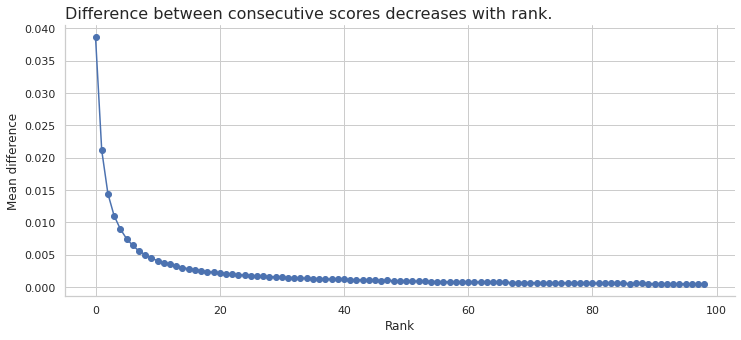

In [30]:
fig ,ax = plt.subplots(figsize=(12,5))
sns.despine(ax=ax)
ax.plot(res, 'o-')
ax.set_title("Difference between consecutive scores decreases with rank.", loc='left', size=16)
ax.set_xlabel("Rank")
ax.set_ylabel("Mean difference");


The small differences are a *symptom of the uncertainty of the model*. Potentially, even if a single user is removed from the dataset, that could reorder a given pair of items. With dither, that uncertainty is somewhat mitigated - lower items get higher exposure at least some of the time.

Dither also introduces the following benefits:
1. **Freshness** - users get a feel that recommendations are more dynamic, even if a precomputed set is used. Be careful though - the recommendations shouldn't change with every request. It is recommended to use a random seed which is based on a time interval like 5 or 10 minutes. That way recommendations stay consistent for a certain period, but still change from time to time.
2. **Diversity and mitigating the popularity bias** - less popular items get a higher exposure.
3. **Mitigating the position bias** - even top items are shuffled from time to time. An added benefit is that this shuffling allows **estimating the position bias** since we can see what the performance of a given item would be when presented in different positions.



For more details on dither please see https://buildingrecommenders.wordpress.com/2015/11/11/dithering/

## Inverse-User Frequency
When studying NLP, the concept of tf-idf is one of the first things to come up. Inverse-user frequency is exactly the same concept, but applied to recommender systems. In NLP, the idf component serves to boost keywords and penalize stopwords. Similarly, in recommender systems it serves to highlight the unique tastes of the user as opposed to the mainstream recommendations. 

The formula is as follows:

$$ iuf(movie) = log\frac{N}{n_{movie}}$$

where **N** is the number of users and $\bf n_{movie}$ is the number of users that rated the given movie.

Let's see some scores. Good examples: Mr. Nobody

In [31]:
total_users = data.userId.nunique()
users_per_movie = data.groupby('movieId2')['userId'].nunique()
iuf = np.log(total_users / users_per_movie)
iuf.name='iuf'

In [54]:
@interact
def explore_iuf(title=''):
    merged = pd.merge(iuf, movies, left_index=True, right_index=True)[['title','iuf']]
    if title == '':
        display(merged)
    else:
        merged = merged.loc[merged.title.str.lower().str.contains(title.lower())]
        display(merged)

interactive(children=(Text(value='', description='title'), Output()), _dom_classes=('widget-interact',))

In order to utilize the inverse user frequency, we just need to multiply the original scores by the inverse user frequency scores.

In [47]:
def get_similar_to_with_iuf(idx, topn=10):
    current_sims = sims[idx].toarray()[0]
    with_udf = current_sims * iuf.values
    sorted_array = with_udf.argsort()[::-1]
    indices = sorted_array
    if topn is not None:
        indices = sorted_array[:topn]
    res = movies.loc[indices]
    res['score'] = with_udf[indices]
    res['original_score'] = current_sims[indices]
    return res

In [52]:
display("No dither")
interact(get_similar_to_text, title='Harry Potter and the Sor', sim_fn=fixed(get_similar_to));

'No dither'

interactive(children=(Text(value='Harry Potter and the Sor', description='title'), Output()), _dom_classes=('w…

In [53]:
display("With dither")
interact(get_similar_to_text, title='Harry Potter and the Sor', sim_fn=fixed(get_similar_to_with_iuf));

'With dither'

interactive(children=(Text(value='Harry Potter and the Sor', description='title'), Output()), _dom_classes=('w…

The effects of integrating inverse-user frequency is to **mitigate the positional bias, the popularity bias and to increase serendipity**.

### New Item / User Boost

Recommender systems are biased towards older content, because they have been around longer and have had more chances to get ratings and interactions. New content, on the other hand, we know nothing about (yet). This problem is also known as the explore/exploit dillemma - should we recommend safe items that the user will most likely be okay with or can we experiment with wilder recommendations so we can learn more about them.

In this case, it helps to boost new content and to additionally boost content from new users. Equivalently, you could also penalize older content.




### Similarity Penalty

So far, we've mostly been looking at individual recommendations, but most often recommendations come in lists. The truth is that we need to optimize the entire list. As we've seen before, recommender systems are pretty good in finding and exploiting similarities. If a given list has **too many similar items**, it has **low diversity**. 

What could be helpful in this case is to introduce some kind of similarity penalty. Items that are too similar to items that appear higher in the list should be pushed further down.

### Utility Model

A user does not need to go through a recommender system in order to consume an item. In the book [Deep Learning for Coders with Fastai and Pytorch: AI Applications Without a PhD](https://github.com/fastai/fastbook) the authors propose the following idea: **train two models**:
1. Train a model that can predict $P(buy| recommend)$
2. Train a model that can predict $P(buy| !recommend)$

Afterwards, we can define the utility function as $P(buy | recommend) - P(buy| !recommend)$ and sort according to the utility scores for each item.

The idea is that a ML model should be providing fresh content that the user is unaware of. It doesn't help to recommend an item that the user would consume whether we show it or not. 

Let's consider a retail example: everybody buys bananas and our banana buying behaviour is hardly influenced by recommender systems. Let's suppose that $P(buy_{banana}| recommend) = 0.1$ and $P(buy_{banana}| ~recommend) = 0.099$. Then the utility would be $0.001$ which would put it lower in the list. 

Now, let's focus on movies. Suppose that the user has already seen Harry Potter 1 and Harry Potter 2. Then, the probabilities would most likely be approximately equal $P(HP3 | HP1, HP2, recommend) \sim P(HP3 | HP1, HP2, !recommend)$, since the user is most probably aware of the series. In that case, it might be more valuable to recommend something like Fantastic Beasts or Narnia or The Hobbit.


### Pricing considerations

So far, we have ignored price, but we have to remember that we are not only helping the customer, but in most cases also trying to increase business revenue.

Thus, it might be important to include the price in the equation. Some naive suggestions:
1. $Score(x) = P(x) * Price(x)$
2. $Score(x) = P(x) * log1p(Price(x))$
3. $Score(x) = P(x) * Price(x)^{0.5}$

In any case, I would suggest deeper research before diving right in. This one seems like a good start: [Incorporating Profit Margins into Recommender Systems: A
Randomized Field Experiment of Purchasing Behavior and
Consumer Trust](https://repository.upenn.edu/cgi/viewcontent.cgi?article=1339&context=marketing_papers)

## Summary